In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata

try:
    mnist = fetch_mldata('MNIST original')
except Exception as ex:        
    from six.moves import urllib
    from scipy.io import loadmat
    import os

    mnist_path = os.path.join(".", "datasets", "mnist-original.mat")

    # download dataset from github.
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)

    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Done!")

X = mnist.data / 255.0
y = mnist.target

print(X.shape, y.shape)

(70000, 784) (70000,)


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape, X_test.shape)

(49000, 784) (21000, 784)


In [3]:
#Creating dataset with only 500 features out of 784
feature_set = 500
X_train_reduced = X_train[:,:feature_set]
X_test_reduced = X_test[:,:feature_set]
X_train_reduced.shape, X_test_reduced.shape

((49000, 500), (21000, 500))

In [5]:
%load_ext autoreload
%autoreload 2
%pylab inline

import tensorflow as tf
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

import sys, os
sys.path.extend([os.path.expanduser('..')])
from pathint import utils
import seaborn as sns
sns.set_style("ticks")

from tqdm import trange, tqdm

# import operator
import matplotlib.colors as colors
import matplotlib.cm as cmx

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

select = tf.select if hasattr(tf, 'select') else tf.where

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['select']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Parameters

In [12]:
# Data params
input_dim = 500
output_dim = 10

# Network params
n_hidden_units = 43
activation_fn = tf.nn.relu

# Optimization params
batch_size = 64
epochs_per_task = 10

n_stats = 1

# Reset optimizer after each age
reset_optimizer = True

## Construct datasets

In [9]:
from keras.utils import np_utils

#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9],[1,5],[7,9],[3,8],[0,6],[4,2]]
#task_labels = [[8,9], [6,7], [4,5], [2,3], [0,1]]
#task_labels = [[0,9], [7,8], [3,6], [1,4], [2,5]]
#task_labels = [[0,1,2], [3,4,5], [6,7,8,9]]
#task_labels = [[1,5,8],[2,5,7,9],[3,4,6]]
task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
n_tasks = len(task_labels)
nb_classes  = 10
training_datasets = []
validation_datasets = []
multihead=False

from sklearn.decomposition import PCA
pca = PCA(n_components=feature_set)

for labels in task_labels:
    idx = np.in1d(Y_train, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        if labels == [0,1] or labels ==[2,3]:
            data = X_train_reduced[idx], np_utils.to_categorical(label_map[Y_train[idx]], len(labels))
        else:
            dimesnion_reduced = pca.fit_transform(X_train[idx])
            data = dimesnion_reduced, np_utils.to_categorical(label_map[Y_train[idx]], len(labels))
    else:
        if labels == [0,1] or labels ==[2,3]:
            data = X_train_reduced[idx], np_utils.to_categorical(Y_train[idx], nb_classes)
        else:
            dimesnion_reduced = pca.fit_transform(X_train[idx])
            data = dimesnion_reduced, np_utils.to_categorical(Y_train[idx], nb_classes)
        training_datasets.append(data)

for labels in task_labels:
    idx = np.in1d(Y_test, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        if labels == [0,1] or labels ==[2,3]:
            data = X_test_reduced[idx], np_utils.to_categorical(label_map[Y_test[idx]], len(labels))
        else:
            dimesnion_reduced = pca.fit_transform(X_test[idx])
            data = dimesnion_reduced, np_utils.to_categorical(label_map[Y_test[idx]], len(labels))
    else:
        if labels == [0,1] or labels ==[2,3]:
            data = X_test_reduced[idx], np_utils.to_categorical(Y_test[idx], nb_classes)
        else:
            dimesnion_reduced = pca.fit_transform(X_test[idx])
            data = dimesnion_reduced, np_utils.to_categorical(Y_test[idx], nb_classes)
        validation_datasets.append(data)

In [10]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())
import keras.backend as K
import keras.activations as activations

output_mask = tf.Variable(tf.zeros(output_dim), name="mask", trainable=False)

def masked_softmax(logits):
    # logits are [batch_size, output_dim]
    x = select(tf.tile(tf.equal(output_mask[None, :], 1.0), [tf.shape(logits)[0], 1]), logits, -1e32 * tf.ones_like(logits))
    return activations.softmax(x)

def set_active_outputs(labels):
    new_mask = np.zeros(output_dim)
    for l in labels:
        new_mask[l] = 1.0
    sess.run(output_mask.assign(new_mask))
    print(sess.run(output_mask))
    
def masked_predict(model, data, targets):
    pred = model.predict(data)
    print(pred)
    acc = np.argmax(pred,1)==np.argmax(targets,1)
    return acc.mean()

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
model = Sequential()
model.add(Dense(n_hidden_units, kernel_initializer='random_uniform', activation=activation_fn, input_shape=(input_dim,)))
#model.add(Dense(n_hidden_units, kernel_initializer='random_uniform', activation=activation_fn))
#model.add(Dense(n_hidden_units, activation=activation_fn))
model.add(Dense(output_dim, kernel_initializer='random_uniform', activation=masked_softmax))

from pathint import protocols
from pathint.optimizers import KOOptimizer
from keras.optimizers import Adam, RMSprop,SGD
from keras.callbacks import Callback
from pathint.keras_utils import LossHistory

#protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
#protocol_name, protocol = protocols.FISHER_PROTOCOL('sum')
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
#opt = SGD(1e-3)
#opt = RMSprop(lr=1e-3)
oopt = KOOptimizer(opt, model=model, **protocol)
model.compile(loss='categorical_crossentropy', optimizer=oopt, metrics=['accuracy'])
model.model._make_train_function()
saved_weights = model.get_weights()

history = LossHistory()
callbacks = [history]
datafile_name = "split_mnist_data_%s.pkl.gz"%protocol_name

In [14]:
def run_fits(cvals, training_data, valid_data, eval_on_train_set=False, nstats=1):
    acc_mean = dict()
    acc_std = dict()
    model_weights_save = []   #Empty list to save the model weights aftertraining each task
    for cidx, cval_ in enumerate(tqdm(cvals)):
        runs = []
        for runid in range(nstats):
            sess.run(tf.global_variables_initializer())
            # model.set_weights(saved_weights)
            cstuffs = []
            evals = []
            print("setting cval")
            cval = cval_
            oopt.set_strength(cval)
            oopt.init_task_vars()
            print("cval is", sess.run(oopt.lam))
            for age, tidx in enumerate(range(n_tasks)):
                print("Age %i, cval is=%f"%(age,cval))
                print("settint output mask")
                set_active_outputs(task_labels[age])
                stuffs = model.fit(training_data[tidx][0], training_data[tidx][1], batch_size, epochs_per_task, callbacks=callbacks)
                oopt.update_task_metrics(training_data[tidx][0], training_data[tidx][1], batch_size)
                oopt.update_task_vars()
                ftask = []
                model_weights_save.append(model.get_weights()) #Save the model weights aftertraining each task
                for j in range(n_tasks):
                    set_active_outputs(task_labels[j])
                    if eval_on_train_set:
                        f_ = masked_predict(model, training_data[j][0], training_data[j][1])
                    else:
                        f_ = masked_predict(model, valid_data[j][0], valid_data[j][1])
                    ftask.append(np.mean(f_))
                evals.append(ftask)
                cstuffs.append(stuffs)

                # Re-initialize optimizater variables
                if reset_optimizer:
                    oopt.reset_optimizer()

            evals = np.array(evals)
            runs.append(evals)
        
        runs = np.array(runs)
        acc_mean[cval_] = runs.mean(0)
        acc_std[cval_] = runs.std(0)
    return dict(mean=acc_mean, std=acc_std),model_weights_save

In [15]:
# cvals = np.concatenate(([0], np.logspace(-2, 2, 10)))
# cvals = np.concatenate(([0], np.logspace(-1, 2, 2)))
# cvals = np.concatenate(([0], np.logspace(-2, 0, 3)))
#cvals = np.logspace(-3, 3, 7)#[0, 1.0, 2, 5, 10]
cvals = [1.0]
print(cvals)

[1.0]


In [16]:
#%%capture

recompute_data = True

if recompute_data:
    data,model_weights_save = run_fits(cvals, training_datasets, validation_datasets, eval_on_train_set=False, nstats=n_stats)
    utils.save_zipped_pickle(data, datafile_name)

  0%|          | 0/1 [00:00<?, ?it/s]

setting cval
cval is 1.0
Age 0, cval is=1.000000
settint output mask
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Epoch 1/10
10447/10447 [==============================] - 0s - loss: 0.0867 - acc: 0.9942     
Epoch 2/10
10447/10447 [==============================] - 0s - loss: 0.0047 - acc: 0.9987     
Epoch 3/10
10447/10447 [==============================] - 0s - loss: 0.0033 - acc: 0.9990     
Epoch 4/10
10447/10447 [==============================] - 0s - loss: 0.0027 - acc: 0.9992     
Epoch 5/10
10447/10447 [==============================] - 0s - loss: 0.0021 - acc: 0.9993     
Epoch 6/10
10447/10447 [==============================] - 0s - loss: 0.0020 - acc: 0.9993     
Epoch 7/10
10447/10447 [==============================] - 0s - loss: 0.0016 - acc: 0.9995     
Epoch 8/10
10447/10447 [==============================] - 0s - loss: 0.0013 - acc: 0.9995      
Epoch 9/10
10447/10447 [==============================] - 0s - loss: 0.0011 - acc: 0.9996       
Epoch 10/10
10447/10447 [================

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
[[0.         0.         0.         ... 0.4965336  0.         0.        ]
 [0.         0.         0.         ... 0.57475364 0.         0.        ]
 [0.         0.         0.         ... 0.5518646  0.         0.        ]
 ...
 [0.         0.         0.         ... 0.5595555  0.         0.        ]
 [0.         0.         0.         ... 0.4403472  0.         0.        ]
 [0.         0.         0.         ... 0.49232227 0.         0.        ]]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
[[0.         0.         0.         ... 0.         0.47682685 0.5231731 ]
 [0.         0.         0.         ... 0.         0.53828645 0.4617135 ]
 [0.         0.         0.         ... 0.         0.64318097 0.35681906]
 ...
 [0.         0.         0.         ... 0.         0.52108324 0.47891682]
 [0.         0.         0.         ... 

100%|██████████| 1/1 [00:23<00:00, 23.03s/it]

[0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  9.96476948e-01 3.52308201e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.85811822e-03 9.98141885e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  9.96873438e-01 3.12659913e-03]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  8.98861587e-01 1.01138346e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  9.99981642e-01 1.83383981e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  8.77536952e-01 1.22463070e-01]]


In [17]:
import h5py
print(model.summary())
model.save_weights('saved_weights.h5') #This file cannot be opend normaly to view the weghts. It can be loaded through load_model() or can be opend via hdf5 viewer

#Shape of the array containg model weights
a_list = model.get_weights()
for i in range(len(a_list)):
    print((np.array(a_list[i])).shape)

#a_list[0][0][0] = a_list[0][0][0]+0.00001
#print(a_list[0][0][0])
#model.set_weights(a_list)

#from keras.utils.vis_utils import plot_model
#import pydot
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 43)                21543     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                440       
Total params: 21,983
Trainable params: 21,983
Non-trainable params: 0
_________________________________________________________________
None
(500, 43)
(43,)
(43, 10)
(10,)


In [18]:
data = utils.load_zipped_pickle(datafile_name)
print(cvals)

[1.0]


In [19]:
print(data)

{'mean': {1.0: array([[0.99884607, 0.50542709, 0.42906919, 0.48301536, 0.5220034 ],
       [0.99884607, 0.96814535, 0.44798407, 0.48627268, 0.53294432],
       [0.99884607, 0.96814535, 0.95470383, 0.45416473, 0.68247022],
       [0.99884607, 0.96814535, 0.95818815, 0.98557469, 0.67882324],
       [0.99884607, 0.96838131, 0.95893479, 0.98557469, 0.94407975]])}, 'std': {1.0: array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])}}


In [20]:
import matplotlib.colors as colors
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=-5, vmax=np.log(np.max(list(data['mean'].keys()))))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
print(scalarMap.get_clim())

(-5.0, 0.0)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


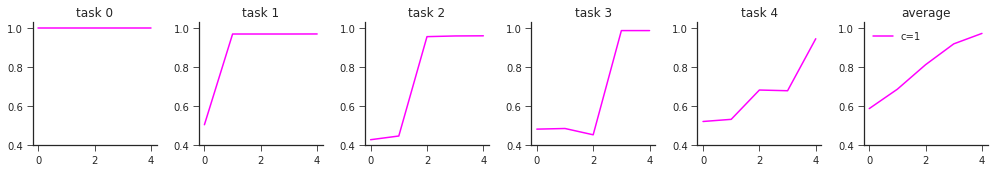

In [21]:
figure(figsize=(14, 2.5))
axs = [subplot(1,n_tasks+1,1)]#, None, None]
for i in range(1, n_tasks + 1):
    axs.append(subplot(1, n_tasks+1, i+1, sharex=axs[0], sharey=axs[0]))
    
keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        colorVal = scalarMap.to_rgba(np.log(cval))
        # axs[j].plot(evals[:, j], c=colorVal)
        axs[j].errorbar(range(n_tasks), mean_vals[:, j], yerr=std_vals[:, j]/np.sqrt(n_stats), c=colorVal)
    label = "c=%g"%cval
    average = mean_vals.mean(1)  #Taking the average of cross validation accuracies accross all tasks after learning each task
    axs[-1].plot(average, c=colorVal, label=label)
    
for i, ax in enumerate(axs):
    ax.legend(loc='best')
    ax.set_title((['task %d'%j for j in range(n_tasks)] + ['average'])[i])
gcf().tight_layout()
sns.despine()
plt.savefig('MNIST-5Task-Progressive-Transfer-Learning.pdf')

In [22]:
for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
       print(mean_vals[:, j],std_vals[:, j]/np.sqrt(n_stats))

[0.99884607 0.99884607 0.99884607 0.99884607 0.99884607] [0. 0. 0. 0. 0.]
[0.50542709 0.96814535 0.96814535 0.96814535 0.96838131] [0. 0. 0. 0. 0.]
[0.42906919 0.44798407 0.95470383 0.95818815 0.95893479] [0. 0. 0. 0. 0.]
[0.48301536 0.48627268 0.45416473 0.98557469 0.98557469] [0. 0. 0. 0. 0.]
[0.5220034  0.53294432 0.68247022 0.67882324 0.94407975] [0. 0. 0. 0. 0.]


In [23]:
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


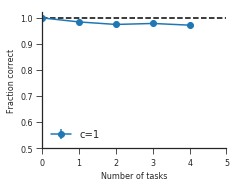

In [30]:
#Fractional Correctness = Average of cross validation accuracies of learned tasks only after training each task 
fig = plt.figure(figsize=(3.3,2.5))
ax = plt.subplot(111)

for cval in sorted_keys:
    mean_stuff = []
    std_stuff = []
    for i in range(len(data['mean'][cval])):
        mean_stuff.append(data['mean'][cval][i][:i+1].mean())
        std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
    # plot(range(1,n_tasks+1), mean_stuff, 'o-', label="c=%g"%cval)
    errorbar(range(0,n_tasks), mean_stuff, yerr=std_stuff, fmt='o-', label="c=%g"%cval)
        
axhline(data['mean'][cval][0][0], linestyle='--', color='k')
xlabel('Number of tasks')
ylabel('Fraction correct')
legend(loc='best')
xlim(0, n_tasks)
ylim(0.5, 1.02)
# grid('on')
# sns.despine()
simple_axis(ax)
plt.savefig('MNIST-5Task-Progressive-Transfer-Learning-fraction-correct.pdf')

In [31]:
#After Reducng dataset
for j in range(n_tasks):
    print('Rank of data for task-{0} of shape-{1} is: {2}'.format(j,training_datasets[j][0].shape,matrix_rank(np.matrix(training_datasets[j][0], dtype='float'))))
    print('----------------------------------------------------------------------')

Rank of data for task-0 of shape-(10447, 500) is: 384
----------------------------------------------------------------------
Rank of data for task-1 of shape-(9893, 500) is: 410
----------------------------------------------------------------------
Rank of data for task-2 of shape-(9119, 500) is: 500
----------------------------------------------------------------------
Rank of data for task-3 of shape-(9871, 500) is: 500
----------------------------------------------------------------------
Rank of data for task-4 of shape-(9670, 500) is: 500
----------------------------------------------------------------------
